In [1]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = "LSTM"
base_log_dir = Path("../../yaib_logs")
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'

hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]

hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    
format_metric = {'ACC': 'Test Accuracy',
                 'ACC_TEST': 'Test Accuracy',
                 'AUC_TEST': 'Test AUC',
                 'AUC': 'Test AUC'}

In [8]:
base_avg = np.load(f"../results/base/{model}-n1000-avg.npz", allow_pickle=True)
base_std = np.load(f"../results/base/{model}-n1000-std.npz", allow_pickle=True)
base_ci = np.load(f"../results/base/{model}-n1000-ci.npz", allow_pickle=True)

add_subgroup_avg = np.load(f"../results/add_subgroup/{model}-n1000-avg.npz", allow_pickle=True)
add_subgroup_std = np.load(f"../results/add_subgroup/{model}-n1000-std.npz", allow_pickle=True)
add_subgroup_ci = np.load(f"../results/add_subgroup/{model}-n1000-ci.npz", allow_pickle=True)

add_subgroup_1000_avg = np.load(f"../results/add_subgroup/{model}-n1000-avg.npz", allow_pickle=True)
add_subgroup_1000_std = np.load(f"../results/add_subgroup/{model}-n1000-std.npz", allow_pickle=True)
add_subgroup_1000_ci = np.load(f"../results/add_subgroup/{model}-n1000-ci.npz", allow_pickle=True)

add_data_1000_avg = np.load(f"../results/add_data/{model}-n1000-avg.npz", allow_pickle=True)
add_data_1000_std = np.load(f"../results/add_data/{model}-n1000-std.npz", allow_pickle=True)
add_data_1000_ci = np.load(f"../results/add_data/{model}-n1000-ci.npz", allow_pickle=True)

## 1. Whole Hospital Data Addition

In this section, aggregate and analyze results for `train{hos1}-{hos2}-test{hos2}-n1000` experiments. This is different from experiments described in `data_analysis.ipynb` because we set the addition cap to 1000 samples per hospital, and allow the test hospital to be added to itself (resulting in a training dataset of 2000 samples from the test hospital).

In [3]:
 
# np.fill_diagonal(data, np.nan)
plt.figure(figsize=(12, 10))

min_val = np.nanmin(data)
max_val = np.nanmax(data)
limit = max(abs(min_val), abs(max_val))

ax = sns.heatmap(data, annot=True, cmap='coolwarm_r', 
            xticklabels=hospital_ids, yticklabels=hospital_ids, 
            vmin=-limit, vmax=limit, center=0)

# Outline the diagonal cells
num_rows, num_cols = data.shape
for i in range(min(num_rows, num_cols)):  # Diagonal index
    rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2)
    ax.add_patch(rect)

# plt.title(title)
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital Combination")
plt.show()

NameError: name 'data' is not defined

<Figure size 1200x1000 with 0 Axes>

In [4]:
avg_dict = {} 
std_dict = {} 
ci_dict = {} 

for i, train_hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids): 
        if i == j:
            dir_str = f"train-test{test_hos}-n2000"
        else:
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n1000"
        exp_dir = os.path.join(log_dir, dir_str)
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]
        f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)

        # Modify key_dict to store subgroup-specific matrices
        for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict.keys(): 
                    key_dict[key] = np.zeros((len(hospital_ids), len(hospital_ids)))
                
                key_dict[key][i, j] = key_results[key]

        # Handle confidence intervals separately
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in ci_dict.keys(): 
                ci_dict[key] = (np.zeros((len(hospital_ids), len(hospital_ids))), np.zeros((len(hospital_ids), len(hospital_ids))))
            
            ci_dict[key][0][i, j] = ci[key][0]
            ci_dict[key][1][i, j] = ci[key][1]

FileNotFoundError: [Errno 2] No such file or directory: '../../yaib_logs/eicu/Mortality24/LSTM/train-test73-n2000'

In [10]:
add_data_1000_avg.files

['loss',
 'AUC',
 'PR',
 'AUC_TEST',
 'BACC_TEST',
 'ACC_TEST',
 'gender0_AUC_TEST',
 'gender0_BACC_TEST',
 'gender0_ACC_TEST',
 'gender1_AUC_TEST',
 'gender1_BACC_TEST',
 'gender1_ACC_TEST',
 'race0_AUC_TEST',
 'race0_BACC_TEST',
 'race0_ACC_TEST',
 'race1_AUC_TEST',
 'race1_BACC_TEST',
 'race1_ACC_TEST',
 'race2_AUC_TEST',
 'race2_BACC_TEST',
 'race2_ACC_TEST',
 'race3_AUC_TEST',
 'race3_BACC_TEST',
 'race3_ACC_TEST']

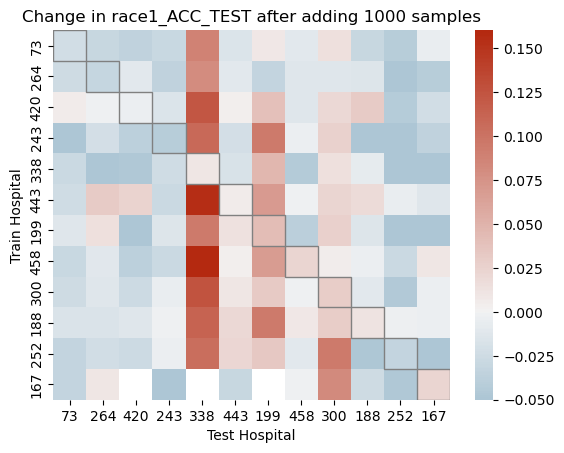

In [11]:
metric = 'ACC_TEST'
col = f'race1_{metric}'

base_values = np.array([base_avg[col].item()[key] for key in base_avg[col].item().keys()]).reshape(1, -1)
plot_data = add_data_1000_avg[col] - base_values

cmap = sns.diverging_palette(240, 15, s=95, l=40, as_cmap=True)
ax = sns.heatmap(plot_data, annot=False, cmap=cmap, 
                xticklabels=hospital_ids, 
                yticklabels=hospital_ids, vmin=-0.05, center=0)

num_rows, num_cols = plot_data.shape
# Outline the diagonal cells
for i in range(min(num_rows, num_cols)):  # Diagonal index
    rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='gray', lw=1)
    ax.add_patch(rect)

ax.set_title(f"Change in {col} after adding 1000 samples")
ax.set_xlabel("Test Hospital")
ax.set_ylabel("Train Hospital")

plt.show()


In [ ]:
# heatmap for worst subgroup AUC/ACC
avg_dict = add_data_1000_avg
col = 'ACC_TEST' # ACC_TEST or AUC_TEST

worst_subgroup_base_values = np.array([min([base_avg[f"race{n}_{col}"].item()[hos] for n in range(1,4)]) for hos in base_avg[col].item().keys()]).reshape(1, -1)
worst_subgroup_values = np.array([
                                    [min([avg_dict[f"race{n}_{col}"][i, j] for n in range(1, 4)]) for j in range(len(hospital_ids))]
                                    for i in range(len(hospital_ids))
                                ])
plot_data = worst_subgroup_values - worst_subgroup_base_values

plt.figure(figsize=(12, 10))

cmap = sns.diverging_palette(240, 15, s=95, l=40, as_cmap=True)
min_val = np.nanmin(plot_data)
max_val = np.nanmax(plot_data)
limit = max(abs(min_val), abs(max_val))

ax = sns.heatmap(plot_data, annot=True, cmap='coolwarm_r', 
            xticklabels=hospital_ids, yticklabels=hospital_ids, 
            vmin=-limit, vmax=limit, center=0)
# num_rows, num_cols = plot_data.shape
# # Outline the diagonal cells
# for i in range(min(num_rows, num_cols)):  # Diagonal index
#     rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='gray', lw=1)
#     ax.add_patch(rect)

# ax.set_title(f"Change in Worst Subgroup {col} after adding 1000 samples")
# ax.set_xlabel("Test Hospital")
# ax.set_ylabel("Train Hospital")

# plt.show()

# Outline the diagonal cells
num_rows, num_cols = plot_data.shape
for i in range(min(num_rows, num_cols)):  # Diagonal index
    rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2)
    ax.add_patch(rect)

plt.title(f"Change in Worst Subgroup {format_metric[metric]}")
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital Combination")
plt.show()


ValueError: operands could not be broadcast together with shapes (10,10) (1,12) 

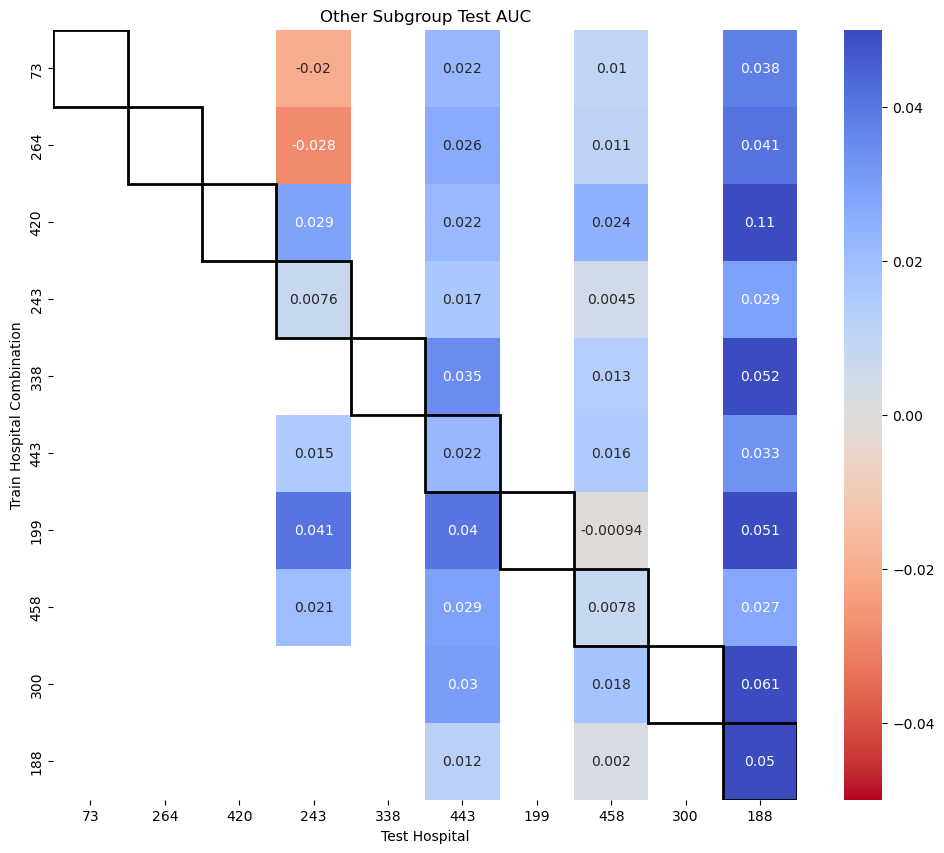

In [32]:
col = 'race1_AUC_TEST'  # or 'ACC_TEST'

# Get base values and reshape to match the matrix dimensions
base_values = np.array([base_avg[col].item()[hos] for hos in base_avg[col].item().keys()]).reshape(1, -1)

# Calculate the difference between avg_dict and base values
plot_data = avg_dict[col] - base_values
plot_data = plot_data[:10, :10]

plt.figure(figsize=(12, 10))

# Create diverging colormap centered at 0
cmap = sns.diverging_palette(240, 15, s=95, l=40, as_cmap=True)
min_val = np.nanmin(plot_data)
max_val = np.nanmax(plot_data)
limit = max(abs(min_val), abs(max_val))
limit = 0.05

# Create heatmap
ax = sns.heatmap(plot_data, annot=True, cmap='coolwarm_r', 
            xticklabels=hospital_ids, yticklabels=hospital_ids, 
            vmin=-limit, vmax=limit, center=0)

# Outline the diagonal cells
num_rows, num_cols = plot_data.shape
for i in range(min(num_rows, num_cols)):
    rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2)
    ax.add_patch(rect)

plt.title(f"Other Subgroup Test AUC")
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital Combination")
plt.show()

## 2. Brute Force Subgroup Only

In [6]:
n = 36
use_n1000 = True

if use_n1000:
    add_subgroup_avg = add_subgroup_1000_avg
    add_subgroup_ci = add_subgroup_1000_ci

race_dict = {'race0': 'asian', 'race1': 'black', 'race2': 'other', 'race3': 'white'}

# Now store lists for each subgroup instead of a single (cmb, improvement).
auc_dict = {hos: {sg: [] for sg in ['black', 'other', 'white']} for hos in hospital_ids}
acc_dict = {hos: {sg: [] for sg in ['black', 'other', 'white']} for hos in hospital_ids}
ci_dict  = {hos: {sg: [] for sg in ['black', 'other', 'white']} for hos in hospital_ids}

base_auc_dict = {hos: {} for hos in hospital_ids}
base_acc_dict = {hos: {} for hos in hospital_ids}
base_ci_dict = {hos: {} for hos in hospital_ids}

for j, test_hos in enumerate(hospital_ids):
    for tgt_subgroup in ['race1', 'race2', 'race3']:
        # 1) Get the base ACC/AUC
        base_auc = base_avg[f"{tgt_subgroup}_AUC_TEST"].item()[test_hos]
        base_acc = base_avg[f"{tgt_subgroup}_ACC_TEST"].item()[test_hos]
        base_ci_tup = base_ci[f"{tgt_subgroup}_AUC_TEST"].item()[test_hos]

        # 2) Store base metrics
        base_auc_dict[test_hos][race_dict[tgt_subgroup]] = base_auc
        base_acc_dict[test_hos][race_dict[tgt_subgroup]] = base_acc
        base_ci_dict[test_hos][race_dict[tgt_subgroup]] = base_ci_tup

        # 3) Collect all ACC, AUC, and CI in lists
        acc_list = []
        auc_list = []
        ci_list = []  # parallel to auc_list, each entry = (ci_lo, ci_hi)

        for i, train_hos in enumerate(hospital_ids):
            for add_subgroup in ['black', 'other', 'white']:
                acc = add_subgroup_avg[add_subgroup].item()[f"{tgt_subgroup}_ACC_TEST"][i, j]
                auc = add_subgroup_avg[add_subgroup].item()[f"{tgt_subgroup}_AUC_TEST"][i, j]

                # Confidence intervals for AUC
                ci_lo = add_subgroup_ci[add_subgroup].item()[f"{tgt_subgroup}_AUC_TEST"][0][i, j]
                ci_hi = add_subgroup_ci[add_subgroup].item()[f"{tgt_subgroup}_AUC_TEST"][1][i, j]

                # Collect for ACC
                acc_list.append((acc, (train_hos, add_subgroup)))

                # Collect for AUC
                auc_list.append((auc, (train_hos, add_subgroup)))
                ci_list.append((ci_lo, ci_hi))  # same index as auc_list

        # 4) Sort ACC descending by value
        acc_list.sort(key=lambda x: x[0], reverse=True)

        # 5) Sort AUC descending by value, but keep the matching CI
        #    Zip each (auc, combo) with its (ci_lo, ci_hi), then sort
        auc_ci_list = list(zip(auc_list, ci_list))
        #  auc_ci_list[i] == ( (auc_value, (train_hos, add_subgroup)), (ci_lo, ci_hi) )
        auc_ci_list.sort(key=lambda x: x[0][0], reverse=True)

        # 6) Build top_n_acc (filtering out results <= base)
        top_n_acc = [
            ((train_hos, add_subgroup), val - base_acc)
            for (val, (train_hos, add_subgroup)) in acc_list[:n]
            # if val > base_acc
        ]

        # 7) Build top_n_auc with CI (filtering out results <= base)
        top_n_auc = []
        for (val, (train_hos, add_subgroup)), (ci_lo, ci_hi) in auc_ci_list[:n]:
            # if val > base_auc:
            improvement = val - base_auc
            top_n_auc.append(((train_hos, add_subgroup), val, improvement, ci_lo, ci_hi))

        # 8) Store these top-n results in the dictionaries
        #    top_n_acc is a list of ( (train_hos, add_subgroup), improvement )
        #    top_n_auc is now a list of ( (train_hos, add_subgroup), improvement, ci_lo, ci_hi )
        acc_dict[test_hos][race_dict[tgt_subgroup]] = top_n_acc
        auc_dict[test_hos][race_dict[tgt_subgroup]] = top_n_auc


In [7]:
rows = []
for test_hos, subgroup_dict in auc_dict.items():
    for tgt_subgroup, top_n_list in subgroup_dict.items():
        for rank, ((train_hos, add_subgroup), val, improvement, ci_lo, ci_hi) in enumerate(top_n_list, start=1):
            rows.append({
                "Test Hos": test_hos,
                "Target Subgroup": tgt_subgroup,
                "Rank": rank,
                "Train Hos": train_hos,
                "Added Subgroup": add_subgroup,
                "AUC After Addition": val,
                "AUC Improvement": improvement,
                "CI Low": ci_lo,
                "CI High": ci_hi
            })

df_auc = pd.DataFrame(rows).sort_values(by=["Test Hos", "Target Subgroup", "Rank"]).reset_index(drop=True)

In [8]:
rows = []
for test_hos, subgroup_dict_auc in base_auc_dict.items():
    # subgroup_dict_auc is a dict: { 'black': <base_auc>, 'other': <base_auc>, 'white': <base_auc> }
    for tgt_subgroup, base_auc_val in subgroup_dict_auc.items():
        # base_acc_dict for the same hosp + subgroup
        base_acc_val = base_acc_dict[test_hos][tgt_subgroup]
        
        # base_ci_dict likewise holds the ACC confidence intervals for the same hosp + subgroup
        ci_tuple = base_ci_dict[test_hos][tgt_subgroup]  # Should be something like (ci_lo, ci_hi)
        ci_lo, ci_hi = ci_tuple  # unpack

        rows.append({
            "Test Hos": test_hos,
            "Target Subgroup": tgt_subgroup,
            "Base AUC": base_auc_val,
            "Base ACC": base_acc_val,
            "Base ACC CI Low": ci_lo,
            "Base ACC CI High": ci_hi
        })

df_base = (
    pd.DataFrame(rows)
    .sort_values(by=["Test Hos", "Target Subgroup"])
    .reset_index(drop=True)
)

#### Relationship with Mortality Rate

In [4]:
df_race = pd.read_csv('ethnic_data.csv')  

# adds race data about ADDED TRAIN HOSPITAL
df_temp = df_auc.merge(df_race, left_on='Train Hos', right_on='hosp_id', how='left')

FileNotFoundError: [Errno 2] No such file or directory: 'ethnic_data.csv'

In [10]:
subgroups = ["white", "black", "other", "asian"]

# 1. Melt the rate columns:
df_rate = df_race.melt(
    id_vars=["hosp_id", "count", "AUC", "ACC"],
    value_vars=[f"{sg}_rate" for sg in subgroups],
    var_name="subgroup_var",
    value_name="subgroup_rate",
)
df_rate["subgroup"] = df_rate["subgroup_var"].str.replace("_rate", "", regex=False)
df_rate = df_rate.drop(columns=["subgroup_var"])  # not needed anymore

# 2. Melt the mort_rate columns:
df_mort = df_race.melt(
    id_vars=["hosp_id", "count", "AUC", "ACC"],
    value_vars=[f"{sg}_mort_rate" for sg in subgroups],
    var_name="subgroup_var",
    value_name="subgroup_mort_rate",
)
df_mort["subgroup"] = df_mort["subgroup_var"].str.replace("_mort_rate", "", regex=False)
df_mort = df_mort.drop(columns=["subgroup_var"])

# 3. Melt the auc columns:
df_auc = df_race.melt(
    id_vars=["hosp_id", "count", "AUC", "ACC"],
    value_vars=[f"{sg}_auc" for sg in subgroups],
    var_name="subgroup_var",
    value_name="subgroup_auc",
)
df_auc["subgroup"] = df_auc["subgroup_var"].str.replace("_auc", "", regex=False)
df_auc = df_auc.drop(columns=["subgroup_var"])

# 4. Melt the acc columns:
df_acc = df_race.melt(
    id_vars=["hosp_id", "count", "AUC", "ACC"],
    value_vars=[f"{sg}_acc" for sg in subgroups],
    var_name="subgroup_var",
    value_name="subgroup_acc",
)
df_acc["subgroup"] = df_acc["subgroup_var"].str.replace("_acc", "", regex=False)
df_acc = df_acc.drop(columns=["subgroup_var"])

# 5. Now merge all these melted DataFrames on the common columns:
df_long = (
    df_rate
    .merge(df_mort, on=["hosp_id", "count", "AUC", "ACC", "subgroup"])
    .merge(df_auc, on=["hosp_id", "count", "AUC", "ACC", "subgroup"])
    .merge(df_acc, on=["hosp_id", "count", "AUC", "ACC", "subgroup"])
)

df_long = df_long[
    [
        "hosp_id", 
        "subgroup", 
        "count", 
        "AUC", 
        "ACC",
        "subgroup_rate", 
        "subgroup_mort_rate",
        "subgroup_auc", 
        "subgroup_acc",
    ]
].sort_values(["hosp_id", "subgroup"])

In [11]:
def plot_scatterplots_by_test_hosp(df_temp):
    """
    Creates up to 12 subplots, one for each unique "Test Hos".

    X-axis = [Added Subgroup]_mort_rate
    Y-axis = AUC Improvement

    Also returns a DataFrame of correlation coefficients (and p-values)
    for each ("Test Hos", "Target Subgroup").
    """

    # 1) Create a temporary column for the x-axis based on "Added Subgroup"
    df_temp['x_val'] = df_temp.apply(
        lambda row: row[f"{row['Added Subgroup']}_mort_rate"], 
        axis=1
    )

    # 2) Create a temporary column for the y-axis
    df_temp['y_val'] = df_temp['AUC Improvement']

    # 3) Identify unique "Test Hos" values (for subplots)
    test_hospitals = df_temp["Test Hos"].unique()
    num_test_hosp = len(test_hospitals)

    # 4) Create a 6x2 grid of subplots (12 total)
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 30), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten into a list of up to 12 Axes

    # 5) Assign markers to each unique "Target Subgroup"
    unique_subgroups = df_temp["Target Subgroup"].unique()
    possible_markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'P', 'h']
    marker_dict = {}
    for i, sg in enumerate(unique_subgroups):
        marker_dict[sg] = possible_markers[i % len(possible_markers)]

    # 6) We'll collect correlation results in a list of dicts
    corr_records = []

    # Loop through each Test Hos and plot on a separate subplot
    for idx, test_hos in enumerate(test_hospitals):
        # Stop if more than 12 unique "Test Hos"
        if idx >= 12:
            break

        ax = axes[idx]
        sub_df = df_temp[df_temp["Test Hos"] == test_hos]

        # Plot each "Target Subgroup" with a unique marker
        for subgroup in sub_df["Target Subgroup"].unique():
            data_subset = sub_df[sub_df["Target Subgroup"] == subgroup]

            # Compute correlation for this group if enough data points
            if len(data_subset) > 1:
                corr_coef, p_val = pearsonr(data_subset['x_val'], data_subset['y_val'])
                label_text = f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2e})"
            else:
                corr_coef, p_val = None, None
                label_text = f"{subgroup} (r=N/A)"

            # Scatter plot
            ax.scatter(
                data_subset['x_val'],
                data_subset['y_val'],
                marker=marker_dict[subgroup],
                label=label_text,
                s=100,  # point size
            )

            # Collect correlation data (one record per (Test Hos, Target Subgroup))
            corr_records.append({
                "Test Hos": test_hos,
                "Target Subgroup": subgroup,
                "mort_corr": corr_coef,
                "mort_corr_pval": p_val
            })

        # Set titles & labels
        ax.set_title(f"Test Hos: {test_hos}", fontsize=14)
        # "Added Subgroup" is presumably consistent within a Test Hos,
        # but we just take the first row to be safe
        added_subgroup = sub_df['Added Subgroup'].iloc[0]
        ax.set_xlabel(f"mort_rate of Added Subgroup", fontsize=12)
        ax.set_ylabel("AUC Improvement", fontsize=12)
        ax.legend(title="Target Subgroup", fontsize=10)

    # 7) Remove any extra subplots if fewer than 12 test hospitals
    if num_test_hosp < 12:
        for i in range(num_test_hosp, 12):
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    # 8) Convert the correlation list to a DataFrame, remove duplicates, return
    df_corr = pd.DataFrame(corr_records).drop_duplicates(
        subset=["Test Hos", "Target Subgroup"]
    )
    return df_corr

In [ ]:
df_corr = plot_scatterplots_by_test_hosp(df_temp)

In [5]:
df_long = df_long.merge(df_corr, left_on=['hosp_id','subgroup'], right_on=['Test Hos', 'Target Subgroup'], how='left')
df_long.drop(['Test Hos', 'Target Subgroup'], axis=1, inplace=True)

df_long['subgroup_auc'] = df_base['Base AUC']
df_long['subgroup_acc'] = df_base['Base ACC']
df_long['subgroup_auc_ci_lo'] = df_base['Base ACC CI Low']
df_long['subgroup_auc_ci_hi'] = df_base['Base ACC CI High']

NameError: name 'df_long' is not defined

### Visualization: Change in Worst Subgroup AUC After Adding Worst Subgroup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rows = []

for hos in df_base["Test Hos"].unique():
    # --- A) Find the worst base subgroup (lowest Base AUC)
    base_subset = df_base[df_base["Test Hos"] == hos]
    worst_row = base_subset.sort_values("Base AUC").iloc[0]
    worst_subgroup = worst_row["Target Subgroup"]  # e.g., "black", "other", etc.
    
    base_auc = worst_row["Base AUC"]
    # We assume these columns hold the base AUC confidence intervals
    base_ci_low = worst_row["Base ACC CI Low"]
    base_ci_high = worst_row["Base ACC CI High"]
    
    # --- B) Among df_auc, find the new worst subgroup after adding that same worst subgroup
    auc_subset = df_auc[
        (df_auc["Test Hos"] == hos) &
        (df_auc["Train Hos"] == hos) &
        (df_auc["Added Subgroup"] == worst_subgroup)
    ]

    new_worst_row = auc_subset.sort_values("AUC After Addition").iloc[0]
    new_worst_auc = new_worst_row["AUC After Addition"]
    new_ci_low = new_worst_row["CI Low"]
    new_ci_high = new_worst_row["CI High"]
    new_worst_subgroup = new_worst_row["Target Subgroup"]

    
    # --- C) Create two rows: one for base worst, one for new worst
    rows.append({
        "Test Hos": hos,
        "Type": "Base Worst",
        "Worst Subgroup": worst_subgroup,
        "AUC": base_auc,
        "CI Low": base_ci_low,
        "CI High": base_ci_high
    })
    rows.append({
        "Test Hos": hos,
        "Type": "New Worst",
        "Worst Subgroup": new_worst_subgroup,
        "AUC": new_worst_auc,
        "CI Low": new_ci_low,
        "CI High": new_ci_high
    })

plot_df = pd.DataFrame(rows).sort_values(by=["Test Hos", "Type"]).reset_index(drop=True)

# Identify hospitals in sorted order
hosp_list = plot_df["Test Hos"].unique()
hosp_list.sort()

x = np.arange(len(hosp_list))
width = 0.4

base_err = np.array([base_err_lower, base_err_upper])
new_err  = np.array([new_err_lower, new_err_upper])

fig, ax = plt.subplots(figsize=(12,8))

rects_base = ax.bar(
    x - width/2,
    base_vals,
    width,
    yerr=base_err,
    capsize=4,
    label="Base Worst",
    color='red'
)

rects_new = ax.bar(
    x + width/2,
    new_vals,
    width,
    yerr=new_err,
    capsize=4,
    label="New Worst",
    color='green'
)

ax.set_xticks(x)
ax.set_xticklabels(hosp_list, rotation=45)
ax.set_ylabel("AUC")
ax.set_title("Base vs. New Worst Subgroup AUC by Test Hospital")
ax.legend()

# --- Annotate the bars ABOVE the top of the error bar
for rect, sg_label, err_up in zip(rects_base, base_labels, base_err_upper):
    height = rect.get_height()
    # Handle NaNs to avoid placing labels incorrectly
    if np.isnan(height) or np.isnan(err_up):
        continue
    # Place label above top of error bar by 3 points
    y_pos = height + err_up
    ax.annotate(
        sg_label,
        xy=(rect.get_x() + rect.get_width()/2, y_pos),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=90
    )

for rect, sg_label, err_up in zip(rects_new, new_labels, new_err_upper):
    height = rect.get_height()
    if np.isnan(height) or np.isnan(err_up):
        continue
    y_pos = height + err_up
    ax.annotate(
        sg_label,
        xy=(rect.get_x() + rect.get_width()/2, y_pos),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=90
    )

plt.tight_layout()
plt.show()


NameError: name 'df_base' is not defined

#### Multi-dimensional AUC Change Prediction

Feature dataset:
- Test Hos Data
    - Target Subgroup
        - Subgroup Rate
        - Subgroup Count
        - Subgroup Mortality Rate
        - Subgroup Base AUC
        - Subgroup Base ACC
        - Rehosp Correlation & P-Val 
    - General Data
        - Total Count
        - AUC
        - ACC
- Train Hos Data
    - Added Subgroup
        - Subgroup Rate
        - Subgroup Count
        - Subgroup Mortality Rate
        - Subgroup Base AUC
        - Subgroup Base ACC
    - General Data
        - Total Count
        - AUC
        - ACC
- Relationships between Train & Test Hospital
    - Score_XY
    - KL Divergence
    - Change in Race Ratios?

Regression Output: Change in Subgroup AUC
Binary Classification Output: Subgroup AUC {increases, decreases}

In [7]:
df_cartesian = df_long.merge(df_long, how='cross', suffixes=('_train', '_test'))

# Rename columns to include prefixes explicitly
train_columns = {col: f"train_{col}" for col in df_long.columns}
test_columns = {col: f"test_{col}" for col in df_long.columns}

# Rename columns appropriately
df_cartesian.rename(columns={**train_columns, **test_columns}, inplace=True)


df_cartesian = df_cartesian[
    (df_cartesian['subgroup_train'] != 'asian') &
    (df_cartesian['subgroup_test'] != 'asian')
]

df_cartesian = df_cartesian.merge(
    df_temp[['Test Hos', 'Target Subgroup', 'Train Hos', 'Added Subgroup', 'AUC Improvement']],
    left_on=['hosp_id_test', 'subgroup_test', 'hosp_id_train', 'subgroup_train'],
    right_on=['Test Hos', 'Target Subgroup', 'Train Hos', 'Added Subgroup'],
    how='left'
)

df_cartesian.drop(columns=['Test Hos', 'Target Subgroup', 'Train Hos', 'Added Subgroup'], inplace=True)

NameError: name 'df_long' is not defined

In [8]:
columns_to_drop = ['ACC_train', 'mort_corr_train', 'mort_corr_pval_train', 'count_train']
df_cartesian.drop(columns=columns_to_drop, inplace=True)

NameError: name 'df_cartesian' is not defined

In [9]:
## add similarity score information
score_xy = np.load(f"../results/distances/score-xy.npy")
kl_n2000 = np.load(f"../results/distances/KL-n2000.npz")
kl_ratio = np.load(f"../results/distances/KL-ratio-xy-true.npy")

np.fill_diagonal(score_xy, 0.5)
kl_n2000_xy = kl_n2000['KL_xy']

df_cartesian['score_xy'] = df_cartesian.apply(
    lambda row: score_xy[hospital_ids.index(row['hosp_id_train']), hospital_ids.index(row['hosp_id_test'])],
    axis=1
)

df_cartesian['kl_xy'] = df_cartesian.apply(
    lambda row: kl_n2000_xy[0,  hospital_ids.index(row['hosp_id_train']), hospital_ids.index(row['hosp_id_test'])],
    axis=1
)

df_cartesian['kl_ratio_xy'] = df_cartesian.apply(
    lambda row: kl_ratio[hospital_ids.index(row['hosp_id_train']), hospital_ids.index(row['hosp_id_test'])],
    axis=1
)

NameError: name 'df_cartesian' is not defined

In [10]:
df_cartesian['target'] = (df_cartesian['AUC Improvement'] >= 0).astype(int)

X = df_cartesian.drop(columns=['AUC Improvement', 'target'])
y = df_cartesian['target']

# One hot encoding for categorical columns
categorical_cols = ['subgroup_train', 'subgroup_test']
numerical_cols = [col for col in X.columns if col not in categorical_cols]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Step 5: Train the model
clf.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


NameError: name 'df_cartesian' is not defined

In [11]:
# Step 1: Prepare the data
X = df_cartesian.drop(columns=['AUC Improvement'])
y = df_cartesian['AUC Improvement']

# Identify categorical and numerical columns
categorical_cols = ['subgroup_train', 'subgroup_test']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Step 2: Preprocessing pipelines
# Numerical: Impute missing values with the mean
numerical_transformer = SimpleImputer(strategy='mean')

# Categorical: One-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        #('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create the XGBoost regression pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.001, random_state=42))
])

# Step 5: Train the model
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.5f}")
print(f"R2 Score: {r2:.2f}")

NameError: name 'df_cartesian' is not defined

In [12]:
# Step 4: Create the Linear Regression pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 5: Train the model
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error: {mse:.5f}")
print(f"Linear Regression R2 Score: {r2:.2f}")

NameError: name 'preprocessor' is not defined

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Prepare the data
X = df_cartesian.drop(columns=['AUC Improvement'])
y = df_cartesian['AUC Improvement']

# Identify categorical and numerical columns
categorical_cols = ['subgroup_train', 'subgroup_test']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing pipelines
# Numerical: Impute missing values with the mean
numerical_transformer = SimpleImputer(strategy='mean')

# Categorical: One-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        #('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Convert target to numpy array
y = y.values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape for single output
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Define the neural network
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Single output for regression
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
input_size = X_train.shape[1]
model = RegressionNN(input_size)

# Step 3: Define the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# Step 5: Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    mse = mean_squared_error(y_test, y_pred.numpy())
    r2 = r2_score(y_test, y_pred.numpy())

print(f"Neural Network Mean Squared Error: {mse:.5f}")
print(f"Neural Network R2 Score: {r2:.2f}")


NameError: name 'df_cartesian' is not defined

In [ ]:
variance = np.var(y_test)
print(f"Variance of y_test: {variance:.5f}")

normalized_mse = mse / (y_test.max() - y_test.min())**2
print(f"Normalized MSE: {normalized_mse:.5f}")

baseline_pred = np.full_like(y_test, y_test.mean())  # Predict the mean for all samples
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"Baseline R2: {baseline_r2:.5f}")

In [14]:
# One-hot encode categorical columns
categorical_cols = ['subgroup_train', 'subgroup_test']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Convert y to a Pandas Series with a meaningful name
y_series = pd.Series(y, name='AUC Improvement')

# Concatenate X_encoded (numerical) and y_series
correlation_matrix = pd.concat([X_encoded, y_series], axis=1).corr()

# Sort correlations with 'AUC Improvement'
print(correlation_matrix['AUC Improvement'].sort_values(ascending=False))


NameError: name 'X' is not defined